<a href="https://colab.research.google.com/github/Shirui-peng/Deep-Learning-in-Quantitative-Trading/blob/main/Chapter3/02_regress_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
current_dir = os.path.dirname(os.path.abspath("__file__"))
project_dir = os.path.dirname(current_dir)
sys.path.append(project_dir)

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
# from Utilis.early_stopper import EarlyStopping

torch.manual_seed(42)
np.random.seed(42)

In [2]:
class EarlyStopping:
    """
    Early stops the training if validation loss doesn't improve
    after a given patience.
    """
    def __init__(self, savepath, patience=5, min_delta=0.0, verbose=False):
        """
        Args:
            patience  (int): How many epochs to wait after last improvement.
            min_delta (float): Minimum change in monitored value to be considered improvement.
            verbose   (bool): If True, prints a message for each update.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.savepath = savepath

        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, model, val_loss):
        # If no best_loss set yet, treat current as best
        if self.best_loss is None:
            self.best_loss = val_loss
        # Check if there's an improvement
        elif (self.best_loss - val_loss) > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), self.savepath)
            if self.verbose:
                print(f"Validation loss improved. Resetting counter.")
        else:
            # No improvement
            self.counter += 1
            if self.verbose:
                print(f"No improvement in validation loss. Counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

In [3]:
def train_model(model, X_train, y_train, X_val, y_val, X_test,
                savepath, epochs=5, lr=1e-3, batch_size=32, patience=5):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    dataset = torch.utils.data.TensorDataset(X_train, y_train)
    dataloader = torch.utils.data.DataLoader(dataset,
                                             batch_size=batch_size,
                                             shuffle=True)

    early_stopper = EarlyStopping(savepath=savepath, patience=patience, min_delta=1e-4, verbose=True)

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0

        for batch_X, batch_y in dataloader:
            optimizer.zero_grad()
            out = model(batch_X)
            loss = criterion(out, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * batch_X.size(0)

        epoch_loss /= len(dataloader.dataset)
        model.eval()
        with torch.no_grad():
            y_pred_val = model(X_val)
            val_loss = criterion(y_pred_val, y_val).item()

        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train loss: {epoch_loss:.4f}, "
              f"Validation loss: {val_loss:.4f}")

        early_stopper(model, val_loss)
        if early_stopper.early_stop:
            print("Early stopping triggered!")
            break

    model.load_state_dict(torch.load(savepath))
    model.eval()
    y_pred_test = model(X_test)
    return model, y_pred_test

In [4]:
class MLP(nn.Module):
    def __init__(self, seq_length, n_features):
        super(MLP, self).__init__()
        self.flat_dim = seq_length * n_features
        self.net = nn.Sequential(
            nn.Flatten(),                   # (batch, seq_length*n_features)
            nn.Linear(self.flat_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x)

class CNN(nn.Module):
    def __init__(self, n_features, out_channels=32):
        super(CNN, self).__init__()
        # in_channels = n_features, kernel_size=3, padding=1
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels=n_features,
                      out_channels=out_channels,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.Conv1d(out_channels, out_channels,
                      kernel_size=3,
                      padding=1),
            nn.ReLU()
        )
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc   = nn.Linear(out_channels, 1)

    def forward(self, x):
        # x: (batch, seq_length, n_features)
        x = x.permute(0, 2, 1)
        x = self.conv(x)
        x = self.pool(x)        # shape: (batch, out_channels, 1)
        x = x.squeeze(-1)       # (batch, out_channels)
        x = self.fc(x)          # (batch,1)
        return x

class WaveNetLike(nn.Module):
    def __init__(self, n_features, out_channels=32,
                 kernel_size=2, dilation_depth=4):
        super(WaveNetLike, self).__init__()
        layers = []
        in_channels = n_features
        for d in range(dilation_depth):
            dilation_rate = 2 ** d
            padding = (kernel_size - 1) * dilation_rate
            conv = nn.Conv1d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                dilation=dilation_rate,
                padding=padding
            )
            layers.append(conv)
            in_channels = out_channels

        self.convs = nn.ModuleList(layers)
        self.activation = nn.ReLU()
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc   = nn.Linear(out_channels, 1)

    def forward(self, x):
        # x: (batch, seq_length, n_features)
        x = x.permute(0, 2, 1)  # (batch, n_features, seq_length)

        for conv in self.convs:
            x = conv(x)
            x = self.activation(x)

        x = self.pool(x)        # (batch, out_channels, 1)
        x = x.squeeze(-1)       # (batch, out_channels)
        x = self.fc(x)          # (batch,1)
        return x

class LSTMModel(nn.Module):
    def __init__(self, n_features, hidden_size=64):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=n_features,
                            hidden_size=hidden_size,
                            batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        # x: (batch, seq_length, n_features)
        output, (h_n, c_n) = self.lstm(x)
        # output: (batch, seq_length, hidden_size)
        last_output = output[:, -1, :]  # (batch, hidden_size)
        return self.fc(last_output)

class TransformerModel(nn.Module):
    def __init__(self, seq_length, n_features, d_model=64, nhead=4, num_layers=2):
        super(TransformerModel, self).__init__()
        self.d_model = d_model

        self.input_fc = nn.Linear(n_features, d_model)
        self.pos_embedding = nn.Parameter(
            torch.randn(1, seq_length, d_model)
        )

        # TransformerEncoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=128,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        # x: (batch, seq_length, n_features)
        x = self.input_fc(x)  # (batch, seq_length, d_model)

        seq_len = x.size(1)
        x = x + self.pos_embedding[:, :seq_len, :]
        x = self.transformer_encoder(x)  # (batch, seq_length, d_model)

        # Global Average Pooling over seq_length
        x = x.permute(0, 2, 1)
        x = self.pool(x)  # (batch, d_model, 1)
        x = x.squeeze(-1) # (batch, d_model)

        x = self.fc(x)    # (batch, 1)
        return x

In [5]:
# Simiulate some data to perform a regression problem.
# The x inputs have dimension of (batch_samples, time look-back windows, feature numbers).
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
N = 2000
seq_length = 20
n_features = 3

# X: (N, seq_length, n_features)
X_np = np.random.randn(N, seq_length, n_features)
noise = 0.1 * np.random.randn(N)
y_np = 2 * X_np[:, -1, 0] + 3 * X_np[:, -1, 1] - 1.5 * X_np[:, -1, 2] + noise
y_np = y_np.reshape(-1, 1)  # shape (N,1)

split_index_val = int(N * 0.6)
split_index_test = int(N * 0.8)

X_train_np = X_np[:split_index_val]
y_train_np = y_np[:split_index_val]
X_val_np = X_np[split_index_val:split_index_test]
y_val_np = y_np[split_index_val:split_index_test]
X_test_np  = X_np[split_index_test:]
y_test_np  = y_np[split_index_test:]

X_train = torch.tensor(X_train_np, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train_np, dtype=torch.float32).to(device)
X_val = torch.tensor(X_val_np, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val_np, dtype=torch.float32).to(device)
X_test  = torch.tensor(X_test_np,  dtype=torch.float32).to(device)
y_test  = torch.tensor(y_test_np,  dtype=torch.float32).to(device)

print("Train X shape:", X_train.shape)
print("Train y shape:", y_train.shape)
print("Val X shape:", X_val.shape)
print("Val y shape:", y_val.shape)
print("Test  X shape:", X_test.shape)
print("Test  y shape:", y_test.shape)

Using device: cpu
Train X shape: torch.Size([1200, 20, 3])
Train y shape: torch.Size([1200, 1])
Val X shape: torch.Size([400, 20, 3])
Val y shape: torch.Size([400, 1])
Test  X shape: torch.Size([400, 20, 3])
Test  y shape: torch.Size([400, 1])


In [7]:
mlp_model = MLP(seq_length, n_features).to(device)
mlp_model, y_pred_mlp = train_model(mlp_model, X_train, y_train, X_val, y_val, X_test, epochs=40, savepath='best_mlp')

Epoch 1/40, Train loss: 15.7484, Validation loss: 14.0809
Epoch 2/40, Train loss: 13.1948, Validation loss: 9.8617
Validation loss improved. Resetting counter.
Epoch 3/40, Train loss: 6.1184, Validation loss: 2.5932
Validation loss improved. Resetting counter.
Epoch 4/40, Train loss: 1.0160, Validation loss: 0.6606
Validation loss improved. Resetting counter.
Epoch 5/40, Train loss: 0.4191, Validation loss: 0.4950
Validation loss improved. Resetting counter.
Epoch 6/40, Train loss: 0.2775, Validation loss: 0.4040
Validation loss improved. Resetting counter.
Epoch 7/40, Train loss: 0.2019, Validation loss: 0.3595
Validation loss improved. Resetting counter.
Epoch 8/40, Train loss: 0.1510, Validation loss: 0.3256
Validation loss improved. Resetting counter.
Epoch 9/40, Train loss: 0.1182, Validation loss: 0.3049
Validation loss improved. Resetting counter.
Epoch 10/40, Train loss: 0.0983, Validation loss: 0.2817
Validation loss improved. Resetting counter.
Epoch 11/40, Train loss: 0.0804

In [8]:
cnn_model = CNN(n_features=3).to(device)
cnn_model, y_pred_cnn = train_model(cnn_model, X_train, y_train, X_val, y_val, X_test, epochs=40, savepath='best_cnn')

Epoch 1/40, Train loss: 16.1519, Validation loss: 15.0641
Epoch 2/40, Train loss: 16.0502, Validation loss: 14.9864
Validation loss improved. Resetting counter.
Epoch 3/40, Train loss: 15.9633, Validation loss: 14.8769
Validation loss improved. Resetting counter.
Epoch 4/40, Train loss: 15.8263, Validation loss: 14.7182
Validation loss improved. Resetting counter.
Epoch 5/40, Train loss: 15.5723, Validation loss: 14.3600
Validation loss improved. Resetting counter.
Epoch 6/40, Train loss: 15.3205, Validation loss: 14.3624
No improvement in validation loss. Counter: 1/5
Epoch 7/40, Train loss: 15.0125, Validation loss: 13.8340
Validation loss improved. Resetting counter.
Epoch 8/40, Train loss: 14.6984, Validation loss: 13.4453
Validation loss improved. Resetting counter.
Epoch 9/40, Train loss: 14.2781, Validation loss: 13.0414
Validation loss improved. Resetting counter.
Epoch 10/40, Train loss: 13.8304, Validation loss: 12.8491
Validation loss improved. Resetting counter.
Epoch 11/40

In [9]:
wavenet_model = WaveNetLike(n_features=3).to(device)
wavenet_model, y_pred_wavenet = train_model(wavenet_model, X_train, y_train, X_val, y_val, X_test, epochs=40, savepath='best_wavenet')

Epoch 1/40, Train loss: 16.1503, Validation loss: 15.0477
Epoch 2/40, Train loss: 16.0408, Validation loss: 14.9638
Validation loss improved. Resetting counter.
Epoch 3/40, Train loss: 15.7431, Validation loss: 14.4098
Validation loss improved. Resetting counter.
Epoch 4/40, Train loss: 15.0353, Validation loss: 12.9565
Validation loss improved. Resetting counter.
Epoch 5/40, Train loss: 13.3222, Validation loss: 10.9242
Validation loss improved. Resetting counter.
Epoch 6/40, Train loss: 10.7222, Validation loss: 7.3243
Validation loss improved. Resetting counter.
Epoch 7/40, Train loss: 7.2869, Validation loss: 4.7525
Validation loss improved. Resetting counter.
Epoch 8/40, Train loss: 4.0989, Validation loss: 2.0961
Validation loss improved. Resetting counter.
Epoch 9/40, Train loss: 2.3250, Validation loss: 1.5587
Validation loss improved. Resetting counter.
Epoch 10/40, Train loss: 1.5569, Validation loss: 1.3928
Validation loss improved. Resetting counter.
Epoch 11/40, Train loss

In [10]:
lstm_model = LSTMModel(n_features=3).to(device)
lstm_model, y_pred_lstm = train_model(lstm_model, X_train, y_train, X_val, y_val, X_test, epochs=40, savepath='best_lstm')

Epoch 1/40, Train loss: 15.6120, Validation loss: 13.4640
Epoch 2/40, Train loss: 10.3628, Validation loss: 4.8047
Validation loss improved. Resetting counter.
Epoch 3/40, Train loss: 1.7786, Validation loss: 0.1961
Validation loss improved. Resetting counter.
Epoch 4/40, Train loss: 0.1560, Validation loss: 0.0569
Validation loss improved. Resetting counter.
Epoch 5/40, Train loss: 0.0788, Validation loss: 0.0417
Validation loss improved. Resetting counter.
Epoch 6/40, Train loss: 0.0533, Validation loss: 0.0440
No improvement in validation loss. Counter: 1/5
Epoch 7/40, Train loss: 0.0410, Validation loss: 0.0238
Validation loss improved. Resetting counter.
Epoch 8/40, Train loss: 0.0340, Validation loss: 0.0279
No improvement in validation loss. Counter: 1/5
Epoch 9/40, Train loss: 0.0279, Validation loss: 0.0184
Validation loss improved. Resetting counter.
Epoch 10/40, Train loss: 0.0297, Validation loss: 0.0265
No improvement in validation loss. Counter: 1/5
Epoch 11/40, Train los

In [11]:
transformer_model = TransformerModel(seq_length, n_features).to(device)
transformer_model, y_pred_transformer = train_model(transformer_model, X_train, y_train, X_val, y_val, X_test, epochs=40, savepath='best_transformer')

Epoch 1/40, Train loss: 12.7675, Validation loss: 2.9766
Epoch 2/40, Train loss: 2.6177, Validation loss: 1.1833
Validation loss improved. Resetting counter.
Epoch 3/40, Train loss: 1.1091, Validation loss: 0.3787
Validation loss improved. Resetting counter.
Epoch 4/40, Train loss: 0.5296, Validation loss: 0.1806
Validation loss improved. Resetting counter.
Epoch 5/40, Train loss: 0.3266, Validation loss: 0.2203
No improvement in validation loss. Counter: 1/5
Epoch 6/40, Train loss: 0.2368, Validation loss: 0.1329
Validation loss improved. Resetting counter.
Epoch 7/40, Train loss: 0.1835, Validation loss: 0.1063
Validation loss improved. Resetting counter.
Epoch 8/40, Train loss: 0.1494, Validation loss: 0.1321
No improvement in validation loss. Counter: 1/5
Epoch 9/40, Train loss: 0.1221, Validation loss: 0.0604
Validation loss improved. Resetting counter.
Epoch 10/40, Train loss: 0.0916, Validation loss: 0.0522
Validation loss improved. Resetting counter.
Epoch 11/40, Train loss: 0.

MLP R2 score: 0.9859940409660339
CNN R2 score: 0.6934458613395691
WaveNet R2 score: 0.9934523701667786
LSTM R2 score: 0.9992046356201172
Transformer R2 score: 0.9987460970878601


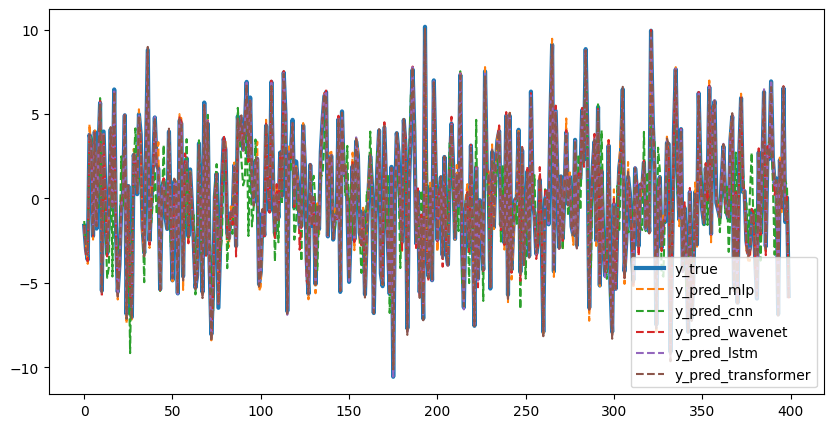

In [15]:
from sklearn.metrics import r2_score
print("MLP R2 score:", r2_score(y_test.detach().numpy(), y_pred_mlp.detach().numpy()))
print("CNN R2 score:", r2_score(y_test.detach().numpy(), y_pred_cnn.detach().numpy()))
print("WaveNet R2 score:", r2_score(y_test.detach().numpy(), y_pred_wavenet.detach().numpy()))
print("LSTM R2 score:", r2_score(y_test.detach().numpy(), y_pred_lstm.detach().numpy()))
print("Transformer R2 score:", r2_score(y_test.detach().numpy(), y_pred_transformer.detach().numpy()))
plt.figure(figsize=(10,5))
plt.plot(y_test, label='y_true', lw = 3)
plt.plot(y_pred_mlp.detach().numpy(), label='y_pred_mlp', ls = 'dashed')
plt.plot(y_pred_cnn.detach().numpy(), label='y_pred_cnn', ls = 'dashed')
plt.plot(y_pred_wavenet.detach().numpy(), label='y_pred_wavenet', ls = 'dashed')
plt.plot(y_pred_lstm.detach().numpy(), label='y_pred_lstm', ls = 'dashed')
plt.plot(y_pred_transformer.detach().numpy(), label='y_pred_transformer', ls = 'dashed')
plt.legend()